# IDENTIFICATION USING BOTH SURROGATE MODELS - COARSE AND FINE

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [16]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

sys.path.append('../../tests/Xaccelerometer_geometric/models')




#### Decide sample to use for experimental data

In [17]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_"+str(sample)

#### Set Bayesian Identification Parameters

In [18]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2
noise


0.005

#### Load Surrogate Models

Load fine model 

In [19]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Load Fine model 
# Initialize and load models for both configurations
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])
# Define forward and gradient functions for the first configuration
fine_model = create_forward_model_function(data_processor_I, model_I)

Load coarse model 

In [20]:
# Import the function coarse_model
from coarse_model import *

num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


load the data 

In [21]:
# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

### Define Priors and Likelyhoods

 Define a custom Uniform random variable class

In [23]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [24]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time))
y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood) 

#points = np.linspace(0,0.0015-1e-5,150)
#phi = lambda t: np.abs(np.cos(2*np.pi*2500*t)) if t < 2.25/2500 and t > 0.25/2500 else 0
#coeff = [1+10*phi(t-1e-5*10) for t in points]
y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10)

### Define a Posterior

In [25]:
# initialise the LinkFactory
my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]



#### Perform least square optimization for each starting point

In [26]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")

# covariance_matrix = np.eye(3)*(np.diag(covariance_matrix))
print('\nWe are using the following covariance matrix\n', covariance_matrix)


Real Params:  [ 0.317228  0.314022 30.854021]
Optimized Params 1: [ 0.31734761  0.31378134 30.89142745]
Optimized Params 2: [ 0.3166776   0.31489854 30.7261253 ]
Optimized Params 3: [ 0.31723238  0.31392522 30.8678917 ]
Optimized Params 4: [ 0.31746927  0.31357597 30.92185444]
Optimized Params 5: [ 0.31699675  0.31423084 30.81877682]

We are using the following covariance matrix
 [[ 8.55742975e-05 -5.49283289e-05  1.19403042e-02]
 [-5.49283289e-05  1.44511067e-04 -1.91087875e-02]
 [ 1.19403042e-02 -1.91087875e-02  2.86685260e+00]]


Set up the proposal

In [27]:
# Adaptive Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.075)
covariance_matrix
# get the maximum a posteriori point / 
#MAP = tda.get_MAP(my_posterior_fine)
#print(MAP)

array([[ 8.55742975e-05, -5.49283289e-05,  1.19403042e-02],
       [-5.49283289e-05,  1.44511067e-04, -1.91087875e-02],
       [ 1.19403042e-02, -1.91087875e-02,  2.86685260e+00]])

#### Do Metropolis Hastings Sampling

In [28]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
# Iterate over each initial guess to set up and run the Markov chain sampler\n",
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                             iterations=3300, n_chains=1,
                               initial_parameters=initial_guess, 
                           subsampling_rate = 3) #adaptive_error_model='state-independent')
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(300, None, 3), groups="posterior")
    # Append the samples to the list\n",
    samples_mh.append(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples\n",
    print("Effective Sample Size: ", az.ess(samples_mh[index]),"\n")

# Computing diagnostics and collecting results\n",
print("Rhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')) ) 
# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  



Sampling chain 1/1


Running chain, α_c = 1.000, α_f = 1.00:   0%|          | 0/3300 [00:00<?, ?it/s]

Running chain, α_c = 0.623, α_f = 0.42: 100%|██████████| 3300/3300 [00:54<00:00, 60.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 368.7
    Offset     float64 8B 364.4
    Thickness  float64 8B 356.5 

Sampling chain 1/1


Running chain, α_c = 0.593, α_f = 0.37: 100%|██████████| 3300/3300 [00:32<00:00, 102.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 392.9
    Offset     float64 8B 331.5
    Thickness  float64 8B 395.5 

Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.42: 100%|██████████| 3300/3300 [00:30<00:00, 109.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 359.7
    Offset     float64 8B 340.9
    Thickness  float64 8B 385.5 

Sampling chain 1/1


Running chain, α_c = 0.603, α_f = 0.29: 100%|██████████| 3300/3300 [00:29<00:00, 111.00it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 349.0
    Offset     float64 8B 308.8
    Thickness  float64 8B 282.7 

Sampling chain 1/1


Running chain, α_c = 0.600, α_f = 0.40: 100%|██████████| 3300/3300 [00:31<00:00, 106.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 312.0
    Offset     float64 8B 340.7
    Thickness  float64 8B 341.4 

Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.002
    Offset     float64 8B 1.003
    Thickness  float64 8B 1.004


### Diagnostics 

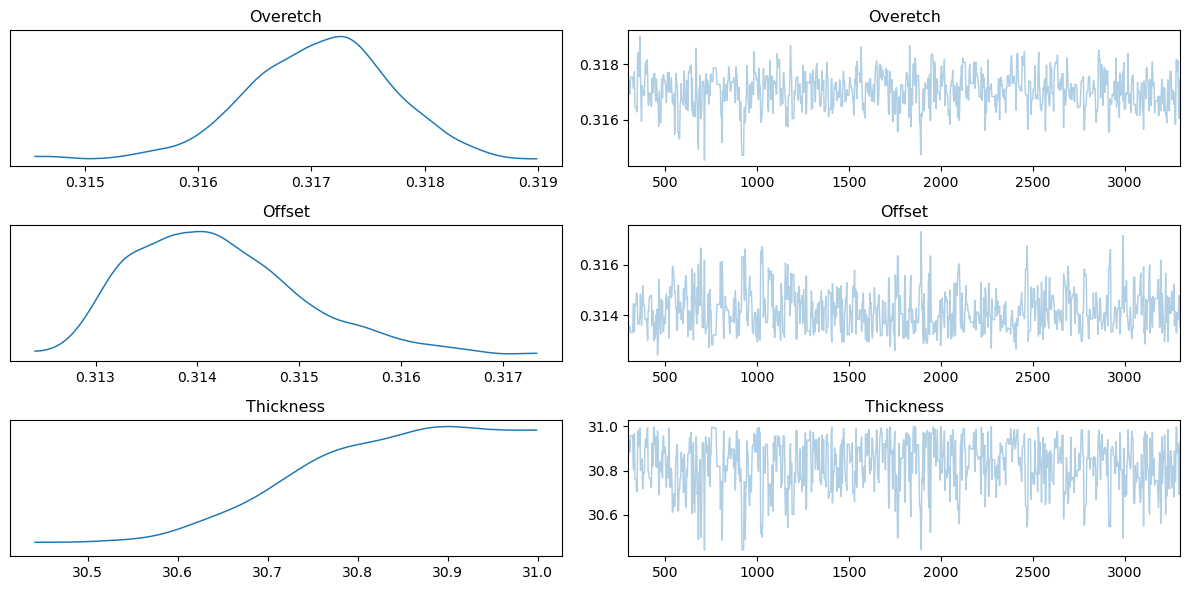

In [29]:
# Plot trace of the first set of samples
#idata = samples_mh[2].sel(draw=slice(MCMC_SETTINGS['Nb'], None,MCMC_SETTINGS['Nt']))
idata = samples_mh[0]
az.plot_trace(idata)
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

In [30]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

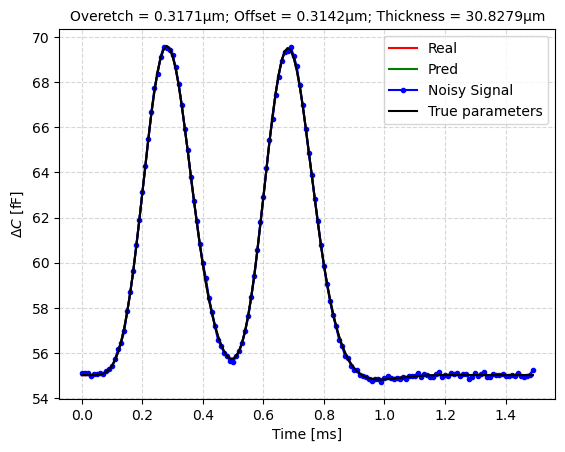

In [31]:
# Plotting and data collection
#data = az.convert_to_dataset
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, model_lf, data)

Finally, let's look at the parameters distribution

In [32]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

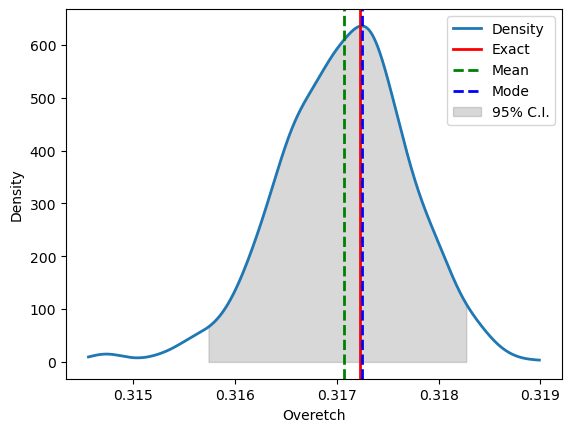

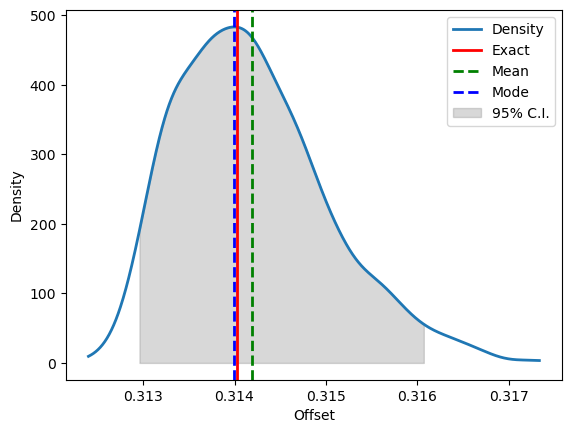

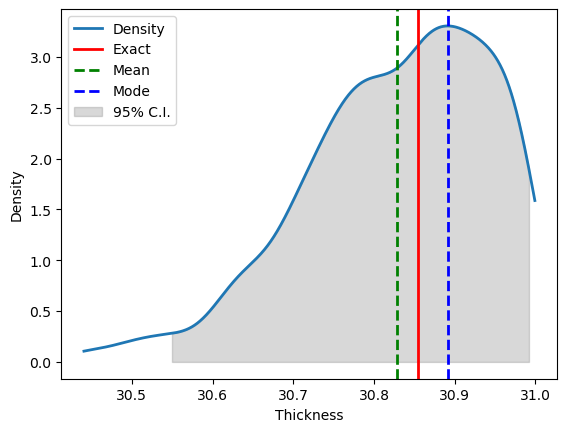

In [33]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

### Post Processing Plots

This section generates the plots in the paper.

In [34]:
from plotsPaper import *
samples = np.load(OUTPUT_FILENAME+'.npy')

##### Histograms of the geometric parameters

In [37]:
def plot_histograms(samples, true_params):

    num_params = samples.shape[0]
    param_names = ['Overetch', 'Offset', 'Thickness']

    sigma = [0.4,1,2]
    avgi = [0.3,0.0,30.0]
    sim_avg = ['Oavg','Uavg','Tavg']
    
    for i in range(num_params):
        plt.figure()
        n, bins, _ = plt.hist(samples[i, :], bins=50, density=True, color='skyblue', edgecolor='black')
        mean_value = np.mean(samples[i, :])
        ci_lower, ci_upper = np.percentile(samples[i, :], [5, 95])

        plt.axvline(true_params[i], color='darkred', linestyle='dashed', linewidth=3, label='True')
        plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=3, label='Mean')
        plt.fill_betweenx([0, max(n)], ci_lower, ci_upper, color='gray', alpha=0.35, label='95% CI')

        ratio_lower = (ci_lower-avgi[i]) / sigma[i]
        ratio_upper = (ci_upper-avgi[i]) / sigma[i]
        sym_lower = ""
        sym_upper = ""
        if ratio_lower>0:
            sym_lower = "+"
        if ratio_upper>0:
            sym_upper = "+"
        s = ['O','U','T']
        #plt.xticks([ci_lower,ci_upper],[sim_avg[i]+sym_lower+f'{ratio_lower:.4f} $\sigma_'+s[i]+'$',sim_avg[i]+sym_upper+f'{ratio_upper:.4f} $\sigma_'+s[i]+'$'])
        plt.xticks([ci_lower,ci_upper],[round(ci_lower,3), round(ci_upper,3)], fontsize = 12)
        plt.xlabel(param_names[i], fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

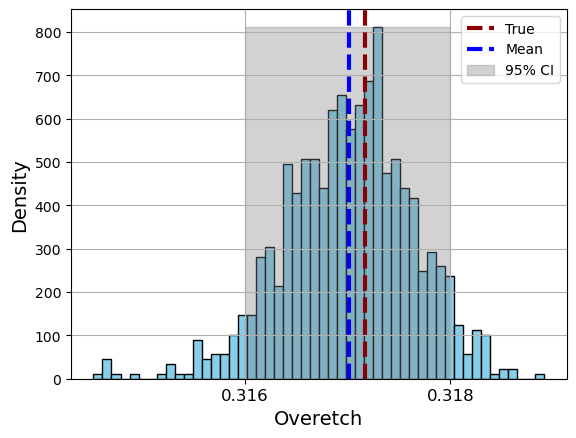

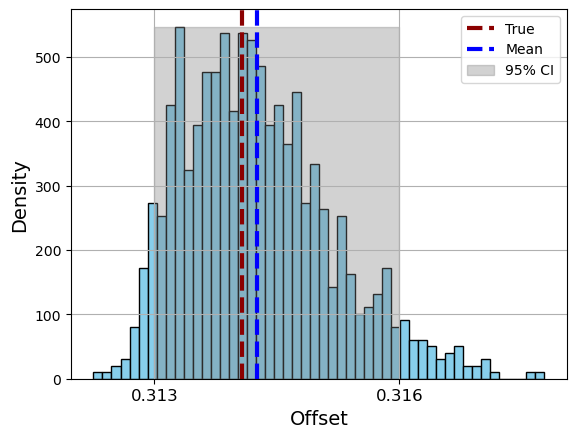

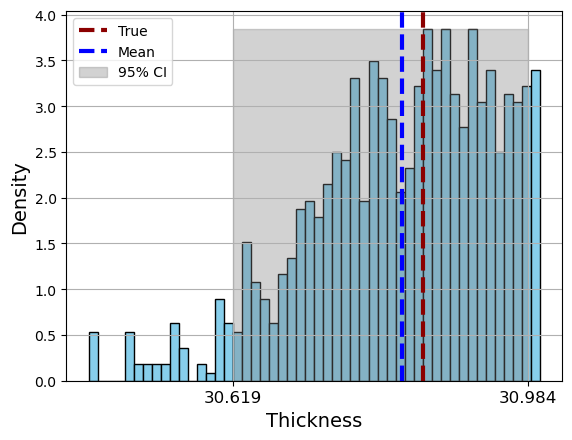

In [38]:
plot_histograms(samples, x_true)

ciao


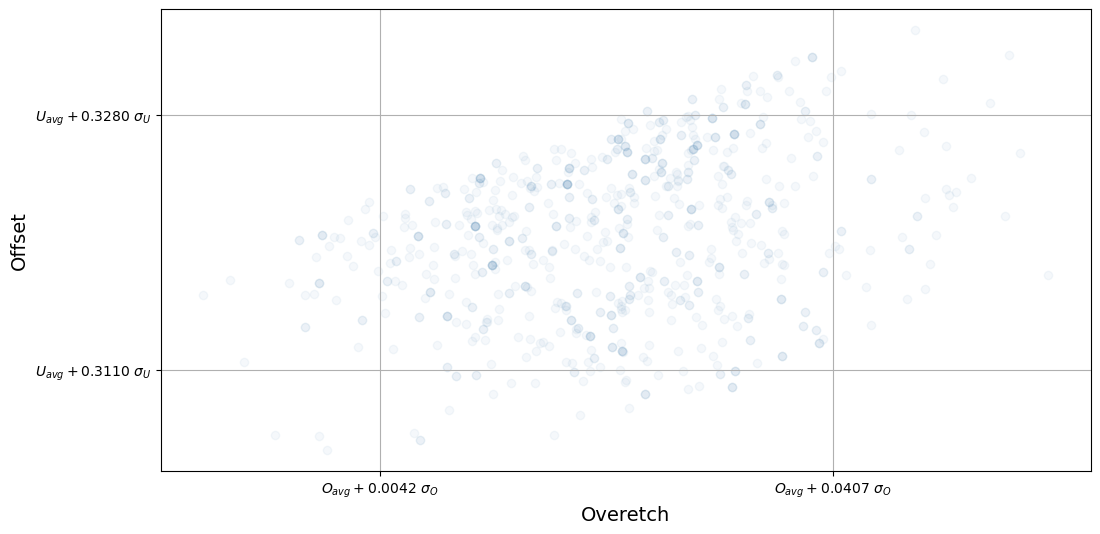

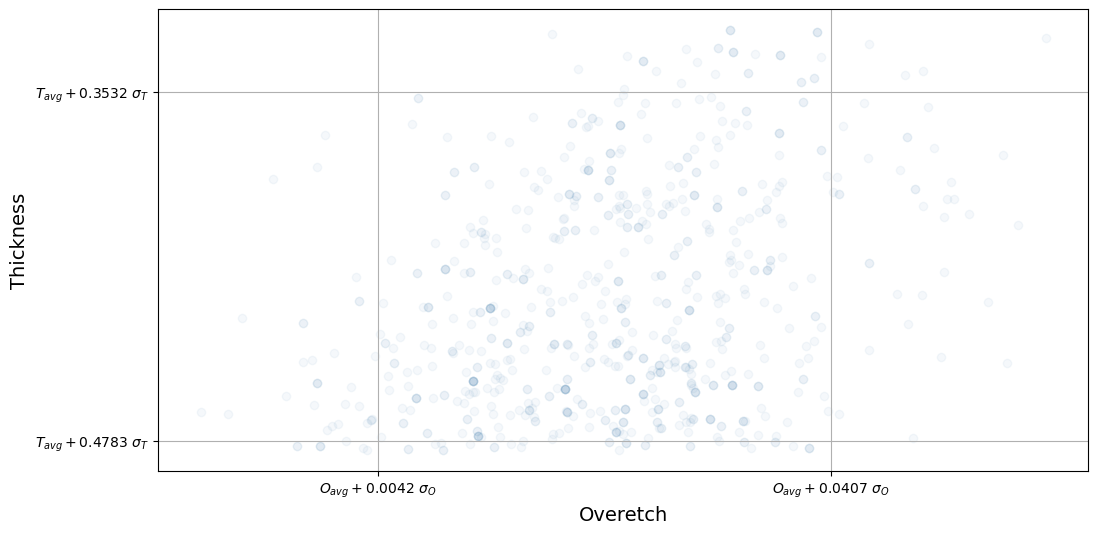

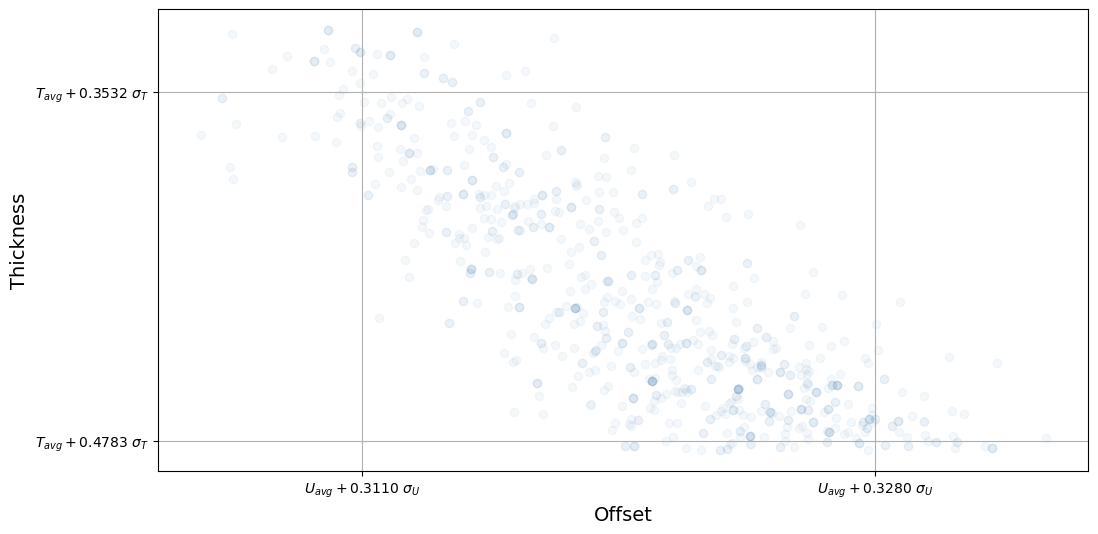

In [ ]:
plot_scatter(samples)

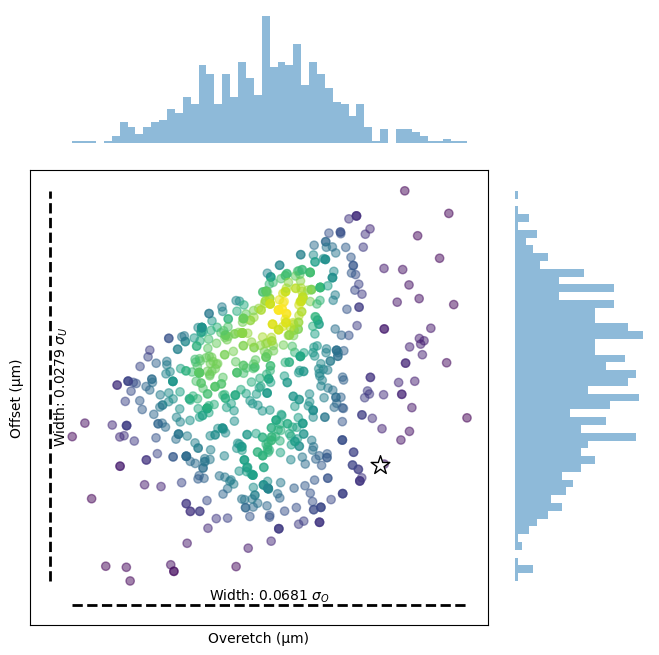

In [ ]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed

### Efficiency comparison 
This section is a first attempt at evaluating the different Time/ESS performances of Fine model and MDA

In [22]:
# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
ESS_values = []
ESS_values_fine = []

for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=3300, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = 3)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(100, None, 3), groups="posterior")
    # Compute the Effective Sample Size (ESS) 
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
    
end_0 = timeit.default_timer() 

my_proposal_fine =  tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.1)
start_1 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior_fine, my_proposal_fine, 
                         iterations=6000, n_chains=1,
                           initial_parameters=initial_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(1000, None, 5), groups="posterior")
    # Compute the Effective Sample Size (ESS)",
    ess = az.ess(idata)
    ESS_values_fine.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
    
end_1 = timeit.default_timer() 

print('Time MDA', (end_0-start_0))
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values)) )
print('Time only fine', (end_1 - start_1))
print('Time/ESS fine',(end_1-start_1)/(5*np.mean(ESS_values_fine, axis = 0)) )
print('\nThe speedup coefficient is:', (end_1 - start_1)/(end_0-start_0))



Sampling chain 1/1


Running chain, α_c = 0.707, α_f = 0.36: 100%|██████████| 3300/3300 [00:12<00:00, 262.00it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.710, α_f = 0.47: 100%|██████████| 3300/3300 [00:12<00:00, 258.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.710, α_f = 0.44: 100%|██████████| 3300/3300 [00:12<00:00, 267.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.673, α_f = 0.39: 100%|██████████| 3300/3300 [00:11<00:00, 276.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.710, α_f = 0.31: 100%|██████████| 3300/3300 [00:12<00:00, 266.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:20<00:00, 288.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.26: 100%|██████████| 6000/6000 [00:20<00:00, 291.00it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:21<00:00, 279.85it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.26: 100%|██████████| 6000/6000 [00:21<00:00, 285.58it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α = 0.32: 100%|██████████| 6000/6000 [00:21<00:00, 278.98it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Time MDA 62.19317329200567
Time/ESS MDA 0.04308976768437702
Time only fine 105.51312750001671
Time/ESS fine [0.07181876 0.06856253 0.07296795]

The speedup coefficient is: 1.6965387343176361


In [28]:
# compute Time/ESS Speedup
time_ess_mda = (end_0-start_0)/(5*np.mean(ESS_values))
time_ess_fine = (end_1-start_1)/(5*np.mean(ESS_values_fine))
print('The Time/ESS speedup coefficient is: ', time_ess_fine/time_ess_mda)

The Time/ESS speedup coefficient is:  1.64927297291316


### Gridsearch for optimal parameters

In [ ]:
subsampling_rate_values = [1, 3, 5 , 10 , 20 , 30 , 100]
scaling_values = [0.01, 0.03, 0.05 , 0.075, 0.09, 0.1, 0.25, 0.5, 0.75, 1 ]

In [ ]:
M = np.zeros((len(subsampling_rate_values), len(scaling_values)))


for index1, ssr in enumerate(subsampling_rate_values):
    for index2, scale in enumerate(scaling_values): 
        # Adaptive Metropolis
        my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
        # Initialize a list to hold the Effective sample sizes for each initial guess
        ESS_values = []
        # Iterate over each initial guess to set up and run the Markov chain sampler
        for index, initial_guess in enumerate(initial_guesses[0:2]):
            samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=4000, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = ssr)
                           #adaptive_error_model='state-independent')
            idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
            # Remove the burnin and sub-sample
            idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
            ess = az.ess(idata)
            ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
            if(index==1):
                print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))

        # Add the mean of the different sample sizes to the matrix
        M[index1, index2] = np.mean(ESS_values)


Sampling chain 1/1


Running chain, α_c = 0.990, α_f = 0.97: 100%|██████████| 4000/4000 [00:17<00:00, 223.66it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.900, α_f = 0.87: 100%|██████████| 4000/4000 [00:17<00:00, 223.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.01    done  1 / 70
Sampling chain 1/1


Running chain, α_c = 0.840, α_f = 0.75: 100%|██████████| 4000/4000 [00:18<00:00, 220.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.830, α_f = 0.74: 100%|██████████| 4000/4000 [00:17<00:00, 222.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.03    done  2 / 70
Sampling chain 1/1


Running chain, α_c = 0.750, α_f = 0.61: 100%|██████████| 4000/4000 [00:16<00:00, 235.45it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.780, α_f = 0.55: 100%|██████████| 4000/4000 [00:16<00:00, 238.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.05    done  3 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.47: 100%|██████████| 4000/4000 [00:16<00:00, 237.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.720, α_f = 0.55: 100%|██████████| 4000/4000 [00:15<00:00, 250.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.075    done  4 / 70
Sampling chain 1/1


Running chain, α_c = 0.500, α_f = 0.28: 100%|██████████| 4000/4000 [00:17<00:00, 233.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.510, α_f = 0.35: 100%|██████████| 4000/4000 [00:17<00:00, 224.56it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.09    done  5 / 70
Sampling chain 1/1


Running chain, α_c = 0.420, α_f = 0.24: 100%|██████████| 4000/4000 [00:15<00:00, 260.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.500, α_f = 0.35: 100%|██████████| 4000/4000 [00:15<00:00, 265.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.1    done  6 / 70
Sampling chain 1/1


Running chain, α_c = 0.190, α_f = 0.03: 100%|██████████| 4000/4000 [00:10<00:00, 396.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.100, α_f = 0.00: 100%|██████████| 4000/4000 [00:10<00:00, 398.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.25    done  7 / 70
Sampling chain 1/1


Running chain, α_c = 0.030, α_f = 0.02: 100%|██████████| 4000/4000 [00:07<00:00, 522.33it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.090, α_f = 0.02: 100%|██████████| 4000/4000 [00:06<00:00, 581.44it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.5    done  8 / 70
Sampling chain 1/1


Running chain, α_c = 0.020, α_f = 0.00: 100%|██████████| 4000/4000 [00:06<00:00, 580.78it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.000, α_f = 0.00: 100%|██████████| 4000/4000 [00:06<00:00, 647.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 0.75    done  9 / 70
Sampling chain 1/1


Running chain, α_c = 0.000, α_f = 0.00: 100%|██████████| 4000/4000 [00:05<00:00, 697.36it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.000, α_f = 0.00: 100%|██████████| 4000/4000 [00:05<00:00, 694.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  1 1    done  10 / 70
Sampling chain 1/1


Running chain, α_c = 0.937, α_f = 0.91: 100%|██████████| 4000/4000 [00:19<00:00, 206.86it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.980, α_f = 0.89: 100%|██████████| 4000/4000 [00:19<00:00, 204.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.01    done  11 / 70
Sampling chain 1/1


Running chain, α_c = 0.813, α_f = 0.60: 100%|██████████| 4000/4000 [00:20<00:00, 192.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.837, α_f = 0.64: 100%|██████████| 4000/4000 [00:18<00:00, 218.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.03    done  12 / 70
Sampling chain 1/1


Running chain, α_c = 0.800, α_f = 0.51: 100%|██████████| 4000/4000 [00:19<00:00, 207.47it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.800, α_f = 0.62: 100%|██████████| 4000/4000 [00:19<00:00, 209.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.05    done  13 / 70
Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.31: 100%|██████████| 4000/4000 [00:18<00:00, 221.35it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.647, α_f = 0.30: 100%|██████████| 4000/4000 [00:17<00:00, 223.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.075    done  14 / 70
Sampling chain 1/1


Running chain, α_c = 0.657, α_f = 0.32: 100%|██████████| 4000/4000 [00:18<00:00, 216.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.620, α_f = 0.31: 100%|██████████| 4000/4000 [00:17<00:00, 226.16it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.09    done  15 / 70
Sampling chain 1/1


Running chain, α_c = 0.610, α_f = 0.35: 100%|██████████| 4000/4000 [00:17<00:00, 225.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.567, α_f = 0.27: 100%|██████████| 4000/4000 [00:17<00:00, 225.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.1    done  16 / 70
Sampling chain 1/1


Running chain, α_c = 0.267, α_f = 0.10: 100%|██████████| 4000/4000 [00:13<00:00, 288.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.217, α_f = 0.04: 100%|██████████| 4000/4000 [00:14<00:00, 276.71it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.25    done  17 / 70
Sampling chain 1/1


Running chain, α_c = 0.057, α_f = 0.00: 100%|██████████| 4000/4000 [00:09<00:00, 428.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.067, α_f = 0.02: 100%|██████████| 4000/4000 [00:09<00:00, 429.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.5    done  18 / 70
Sampling chain 1/1


Running chain, α_c = 0.040, α_f = 0.01: 100%|██████████| 4000/4000 [00:07<00:00, 522.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.033, α_f = 0.00: 100%|██████████| 4000/4000 [00:07<00:00, 536.08it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 0.75    done  19 / 70
Sampling chain 1/1


Running chain, α_c = 0.020, α_f = 0.01: 100%|██████████| 4000/4000 [00:06<00:00, 589.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.013, α_f = 0.00: 100%|██████████| 4000/4000 [00:06<00:00, 590.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  3 1    done  20 / 70
Sampling chain 1/1


Running chain, α_c = 0.968, α_f = 0.88: 100%|██████████| 4000/4000 [00:20<00:00, 199.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.962, α_f = 0.88: 100%|██████████| 4000/4000 [00:18<00:00, 211.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.01    done  21 / 70
Sampling chain 1/1


Running chain, α_c = 0.878, α_f = 0.63: 100%|██████████| 4000/4000 [00:18<00:00, 213.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.900, α_f = 0.63: 100%|██████████| 4000/4000 [00:18<00:00, 210.82it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.03    done  22 / 70
Sampling chain 1/1


Running chain, α_c = 0.828, α_f = 0.45: 100%|██████████| 4000/4000 [00:20<00:00, 197.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.782, α_f = 0.45: 100%|██████████| 4000/4000 [00:18<00:00, 213.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.05    done  23 / 70
Sampling chain 1/1


Running chain, α_c = 0.700, α_f = 0.36: 100%|██████████| 4000/4000 [00:18<00:00, 211.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.674, α_f = 0.36: 100%|██████████| 4000/4000 [00:19<00:00, 206.20it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.075    done  24 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.30: 100%|██████████| 4000/4000 [00:19<00:00, 210.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.640, α_f = 0.31: 100%|██████████| 4000/4000 [00:18<00:00, 211.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.09    done  25 / 70
Sampling chain 1/1


Running chain, α_c = 0.650, α_f = 0.31: 100%|██████████| 4000/4000 [00:18<00:00, 211.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.654, α_f = 0.28: 100%|██████████| 4000/4000 [00:19<00:00, 202.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.1    done  26 / 70
Sampling chain 1/1


Running chain, α_c = 0.310, α_f = 0.11: 100%|██████████| 4000/4000 [00:16<00:00, 239.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.268, α_f = 0.08: 100%|██████████| 4000/4000 [00:17<00:00, 235.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.25    done  27 / 70
Sampling chain 1/1


Running chain, α_c = 0.104, α_f = 0.03: 100%|██████████| 4000/4000 [00:12<00:00, 315.43it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.076, α_f = 0.02: 100%|██████████| 4000/4000 [00:11<00:00, 354.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.5    done  28 / 70
Sampling chain 1/1


Running chain, α_c = 0.042, α_f = 0.02: 100%|██████████| 4000/4000 [00:09<00:00, 442.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.022, α_f = 0.01: 100%|██████████| 4000/4000 [00:09<00:00, 438.51it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 0.75    done  29 / 70
Sampling chain 1/1


Running chain, α_c = 0.008, α_f = 0.00: 100%|██████████| 4000/4000 [00:08<00:00, 477.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.012, α_f = 0.00: 100%|██████████| 4000/4000 [00:08<00:00, 499.45it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  5 1    done  30 / 70
Sampling chain 1/1


Running chain, α_c = 0.955, α_f = 0.80: 100%|██████████| 4000/4000 [00:20<00:00, 192.98it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.946, α_f = 0.78: 100%|██████████| 4000/4000 [00:21<00:00, 181.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.01    done  31 / 70
Sampling chain 1/1


Running chain, α_c = 0.852, α_f = 0.46: 100%|██████████| 4000/4000 [00:22<00:00, 180.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.849, α_f = 0.50: 100%|██████████| 4000/4000 [00:21<00:00, 187.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.03    done  32 / 70
Sampling chain 1/1


Running chain, α_c = 0.785, α_f = 0.28: 100%|██████████| 4000/4000 [08:01<00:00,  8.31it/s] 
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.822, α_f = 0.36: 100%|██████████| 4000/4000 [00:22<00:00, 181.73it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.05    done  33 / 70
Sampling chain 1/1


Running chain, α_c = 0.712, α_f = 0.24: 100%|██████████| 4000/4000 [00:20<00:00, 191.93it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.732, α_f = 0.25: 100%|██████████| 4000/4000 [00:20<00:00, 193.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.075    done  34 / 70
Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.20: 100%|██████████| 4000/4000 [00:20<00:00, 192.63it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.702, α_f = 0.20: 100%|██████████| 4000/4000 [00:20<00:00, 192.01it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.09    done  35 / 70
Sampling chain 1/1


Running chain, α_c = 0.634, α_f = 0.20: 100%|██████████| 4000/4000 [00:21<00:00, 186.39it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.630, α_f = 0.17: 100%|██████████| 4000/4000 [00:21<00:00, 187.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.1    done  36 / 70
Sampling chain 1/1


Running chain, α_c = 0.302, α_f = 0.13: 100%|██████████| 4000/4000 [00:20<00:00, 194.81it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.295, α_f = 0.13: 100%|██████████| 4000/4000 [00:20<00:00, 196.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.25    done  37 / 70
Sampling chain 1/1


Running chain, α_c = 0.072, α_f = 0.02: 100%|██████████| 4000/4000 [00:15<00:00, 255.77it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.085, α_f = 0.05: 100%|██████████| 4000/4000 [00:16<00:00, 248.53it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.5    done  38 / 70
Sampling chain 1/1


Running chain, α_c = 0.032, α_f = 0.02: 100%|██████████| 4000/4000 [00:11<00:00, 336.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.041, α_f = 0.03: 100%|██████████| 4000/4000 [00:12<00:00, 329.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 0.75    done  39 / 70
Sampling chain 1/1


Running chain, α_c = 0.023, α_f = 0.02: 100%|██████████| 4000/4000 [00:10<00:00, 378.92it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.014, α_f = 0.00: 100%|██████████| 4000/4000 [00:10<00:00, 370.71it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  10 1    done  40 / 70
Sampling chain 1/1


Running chain, α_c = 0.973, α_f = 0.66: 100%|██████████| 4000/4000 [00:25<00:00, 158.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.957, α_f = 0.73: 100%|██████████| 4000/4000 [00:24<00:00, 160.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.01    done  41 / 70
Sampling chain 1/1


Running chain, α_c = 0.872, α_f = 0.36: 100%|██████████| 4000/4000 [00:28<00:00, 140.84it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.902, α_f = 0.42: 100%|██████████| 4000/4000 [00:26<00:00, 152.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.03    done  42 / 70
Sampling chain 1/1


Running chain, α_c = 0.824, α_f = 0.20: 100%|██████████| 4000/4000 [00:27<00:00, 145.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.817, α_f = 0.25: 100%|██████████| 4000/4000 [00:26<00:00, 152.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.05    done  43 / 70
Sampling chain 1/1


Running chain, α_c = 0.711, α_f = 0.13: 100%|██████████| 4000/4000 [00:26<00:00, 153.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.734, α_f = 0.15: 100%|██████████| 4000/4000 [00:26<00:00, 149.87it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.075    done  44 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.09: 100%|██████████| 4000/4000 [00:26<00:00, 148.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.663, α_f = 0.14: 100%|██████████| 4000/4000 [00:26<00:00, 150.59it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.09    done  45 / 70
Sampling chain 1/1


Running chain, α_c = 0.651, α_f = 0.18: 100%|██████████| 4000/4000 [00:28<00:00, 137.96it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.653, α_f = 0.16: 100%|██████████| 4000/4000 [00:26<00:00, 153.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.1    done  46 / 70
Sampling chain 1/1


Running chain, α_c = 0.317, α_f = 0.08: 100%|██████████| 4000/4000 [00:27<00:00, 144.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.332, α_f = 0.13: 100%|██████████| 4000/4000 [00:28<00:00, 142.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.25    done  47 / 70
Sampling chain 1/1


Running chain, α_c = 0.091, α_f = 0.04: 100%|██████████| 4000/4000 [00:25<00:00, 155.08it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.090, α_f = 0.06: 100%|██████████| 4000/4000 [00:24<00:00, 162.94it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.5    done  48 / 70
Sampling chain 1/1


Running chain, α_c = 0.036, α_f = 0.04: 100%|██████████| 4000/4000 [00:19<00:00, 200.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.043, α_f = 0.07: 100%|██████████| 4000/4000 [00:20<00:00, 194.11it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 0.75    done  49 / 70
Sampling chain 1/1


Running chain, α_c = 0.021, α_f = 0.01: 100%|██████████| 4000/4000 [00:16<00:00, 236.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.016, α_f = 0.00: 100%|██████████| 4000/4000 [00:18<00:00, 221.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  20 1    done  50 / 70
Sampling chain 1/1


Running chain, α_c = 0.970, α_f = 0.54: 100%|██████████| 4000/4000 [00:30<00:00, 130.07it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.975, α_f = 0.62: 100%|██████████| 4000/4000 [00:30<00:00, 129.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.01    done  51 / 70
Sampling chain 1/1


Running chain, α_c = 0.883, α_f = 0.21: 100%|██████████| 4000/4000 [00:30<00:00, 130.82it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.882, α_f = 0.27: 100%|██████████| 4000/4000 [00:30<00:00, 130.22it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.03    done  52 / 70
Sampling chain 1/1


Running chain, α_c = 0.809, α_f = 0.13: 100%|██████████| 4000/4000 [00:29<00:00, 133.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.839, α_f = 0.24: 100%|██████████| 4000/4000 [00:30<00:00, 131.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.05    done  53 / 70
Sampling chain 1/1


Running chain, α_c = 0.719, α_f = 0.04: 100%|██████████| 4000/4000 [00:30<00:00, 130.72it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.745, α_f = 0.15: 100%|██████████| 4000/4000 [00:29<00:00, 133.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.075    done  54 / 70
Sampling chain 1/1


Running chain, α_c = 0.697, α_f = 0.14: 100%|██████████| 4000/4000 [00:30<00:00, 129.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.719, α_f = 0.12: 100%|██████████| 4000/4000 [00:30<00:00, 130.75it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.09    done  55 / 70
Sampling chain 1/1


Running chain, α_c = 0.670, α_f = 0.16: 100%|██████████| 4000/4000 [00:31<00:00, 128.58it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.639, α_f = 0.04: 100%|██████████| 4000/4000 [00:29<00:00, 134.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.1    done  56 / 70
Sampling chain 1/1


Running chain, α_c = 0.333, α_f = 0.13: 100%|██████████| 4000/4000 [00:30<00:00, 132.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.323, α_f = 0.08: 100%|██████████| 4000/4000 [00:29<00:00, 134.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.25    done  57 / 70
Sampling chain 1/1


Running chain, α_c = 0.102, α_f = 0.15: 100%|██████████| 4000/4000 [00:29<00:00, 136.56it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.111, α_f = 0.15: 100%|██████████| 4000/4000 [00:28<00:00, 140.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.5    done  58 / 70
Sampling chain 1/1


Running chain, α_c = 0.041, α_f = 0.07: 100%|██████████| 4000/4000 [00:24<00:00, 161.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.036, α_f = 0.10: 100%|██████████| 4000/4000 [00:25<00:00, 157.04it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 0.75    done  59 / 70
Sampling chain 1/1


Running chain, α_c = 0.029, α_f = 0.07: 100%|██████████| 4000/4000 [00:22<00:00, 180.88it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.020, α_f = 0.02: 100%|██████████| 4000/4000 [00:21<00:00, 182.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  30 1    done  60 / 70
Sampling chain 1/1


Running chain, α_c = 0.974, α_f = 0.47: 100%|██████████| 4000/4000 [00:56<00:00, 71.25it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.962, α_f = 0.48: 100%|██████████| 4000/4000 [01:58<00:00, 33.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.01    done  61 / 70
Sampling chain 1/1


Running chain, α_c = 0.896, α_f = 0.09: 100%|██████████| 4000/4000 [00:54<00:00, 74.02it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.893, α_f = 0.16: 100%|██████████| 4000/4000 [00:54<00:00, 72.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.03    done  62 / 70
Sampling chain 1/1


Running chain, α_c = 0.829, α_f = 0.14: 100%|██████████| 4000/4000 [00:55<00:00, 72.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.826, α_f = 0.13: 100%|██████████| 4000/4000 [00:54<00:00, 73.15it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.05    done  63 / 70
Sampling chain 1/1


Running chain, α_c = 0.737, α_f = 0.09: 100%|██████████| 4000/4000 [00:57<00:00, 69.74it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.750, α_f = 0.13: 100%|██████████| 4000/4000 [00:56<00:00, 70.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.075    done  64 / 70
Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.02: 100%|██████████| 4000/4000 [00:55<00:00, 71.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.702, α_f = 0.08: 100%|██████████| 4000/4000 [00:54<00:00, 73.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.09    done  65 / 70
Sampling chain 1/1


Running chain, α_c = 0.671, α_f = 0.07: 100%|██████████| 4000/4000 [00:54<00:00, 73.55it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.668, α_f = 0.09: 100%|██████████| 4000/4000 [00:54<00:00, 73.03it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.1    done  66 / 70
Sampling chain 1/1


Running chain, α_c = 0.332, α_f = 0.12: 100%|██████████| 4000/4000 [00:53<00:00, 74.47it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.337, α_f = 0.13: 100%|██████████| 4000/4000 [00:53<00:00, 74.21it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.25    done  67 / 70
Sampling chain 1/1


Running chain, α_c = 0.119, α_f = 0.10: 100%|██████████| 4000/4000 [00:53<00:00, 74.14it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.116, α_f = 0.01: 100%|██████████| 4000/4000 [00:53<00:00, 74.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.5    done  68 / 70
Sampling chain 1/1


Running chain, α_c = 0.044, α_f = 0.06: 100%|██████████| 4000/4000 [00:51<00:00, 77.76it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.043, α_f = 0.11: 100%|██████████| 4000/4000 [00:52<00:00, 75.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 0.75    done  69 / 70
Sampling chain 1/1


Running chain, α_c = 0.019, α_f = 0.05: 100%|██████████| 4000/4000 [00:50<00:00, 79.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Sampling chain 1/1


Running chain, α_c = 0.017, α_f = 0.02: 100%|██████████| 4000/4000 [00:49<00:00, 80.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


sampled with params:  100 1    done  70 / 70


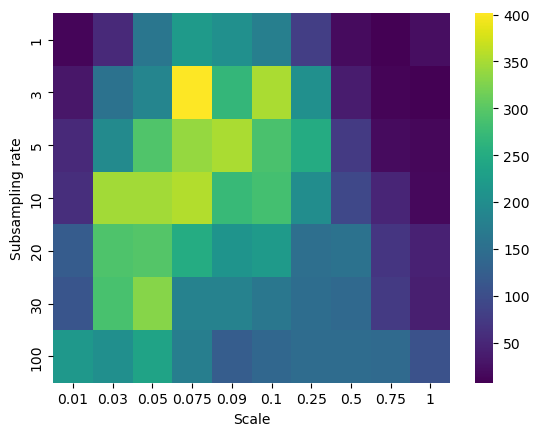

In [ ]:
# Plot heatmap
sns.heatmap(M, cmap='viridis')
plt.xticks(ticks=np.arange(len(scaling_values)) + 0.5, labels=scaling_values)  # Adjust 0.5 offset if needed
plt.yticks(ticks=np.arange(len(subsampling_rate_values)) + 0.5, labels=subsampling_rate_values)  # Adjust 0.5 offset if needed
plt.xlabel('Scale')
plt.ylabel('Subsampling rate')
plt.show()

### See perfomance for 10 samples 

In [32]:
n = 10
random_samples = [ 125,  60,  53,  89,   9,  61, 156,  99,  92, 115] #np.random.choice(np.arange(160), size=n, replace=False)
print('The extracted samples are: ', random_samples)

samples_box = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distr_fine= tda.GaussianLogLike(y_observed, cov_likelihood) 
    y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
    my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)
    my_posteriors = [my_posterior_coarse, my_posterior_fine]    
    
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.075) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posteriors, my_proposal, iterations=3300, n_chains=1, initial_parameters=init_guess,subsampling_rate = 3)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(300, None, 3), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    

The extracted samples are:  [125, 60, 53, 89, 9, 61, 156, 99, 92, 115]
[ 0.164034  0.281502 30.758818]
Sampling chain 1/1


Running chain, α_c = 0.563, α_f = 0.33: 100%|██████████| 3300/3300 [00:12<00:00, 261.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.464787 -0.34692  29.295773]
Sampling chain 1/1


Running chain, α_c = 0.657, α_f = 0.38: 100%|██████████| 3300/3300 [00:11<00:00, 287.27it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.391841  0.24583  29.104798]
Sampling chain 1/1


Running chain, α_c = 0.640, α_f = 0.29: 100%|██████████| 3300/3300 [00:11<00:00, 294.69it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.381797  0.116394 29.238688]
Sampling chain 1/1


Running chain, α_c = 0.680, α_f = 0.29: 100%|██████████| 3300/3300 [00:11<00:00, 283.47it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.417828 -0.33801  29.213157]
Sampling chain 1/1


Running chain, α_c = 0.663, α_f = 0.37: 100%|██████████| 3300/3300 [00:12<00:00, 270.19it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.18104   0.097916 29.566415]
Sampling chain 1/1


Running chain, α_c = 0.680, α_f = 0.24: 100%|██████████| 3300/3300 [00:12<00:00, 258.34it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.339759  0.329625 29.711193]
Sampling chain 1/1


Running chain, α_c = 0.687, α_f = 0.28: 100%|██████████| 3300/3300 [00:12<00:00, 261.83it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.478572 -0.036052 30.60058 ]
Sampling chain 1/1


Running chain, α_c = 0.653, α_f = 0.24: 100%|██████████| 3300/3300 [00:12<00:00, 262.00it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.270542  0.352424 30.628894]
Sampling chain 1/1


Running chain, α_c = 0.630, α_f = 0.37: 100%|██████████| 3300/3300 [00:12<00:00, 263.37it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.493409  0.207659 30.163214]
Sampling chain 1/1


Running chain, α_c = 0.707, α_f = 0.32: 100%|██████████| 3300/3300 [00:12<00:00, 258.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


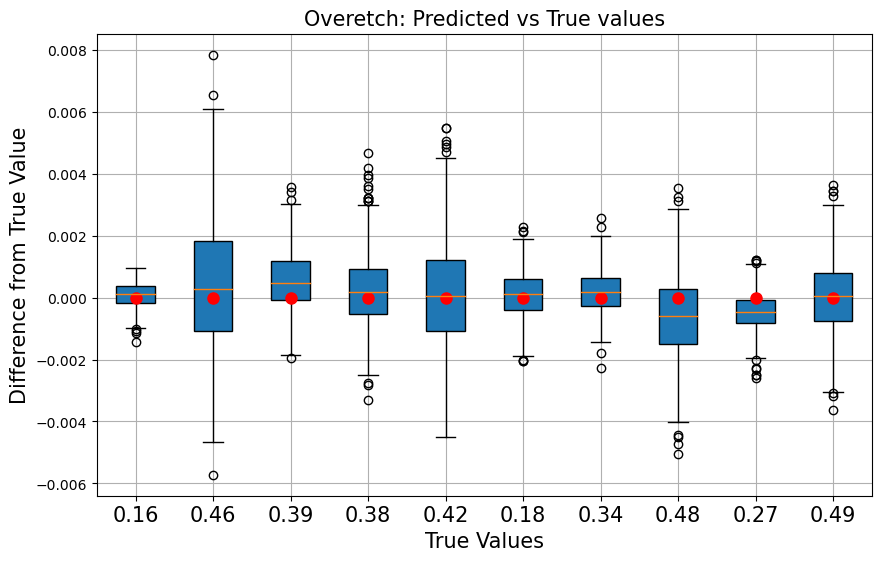

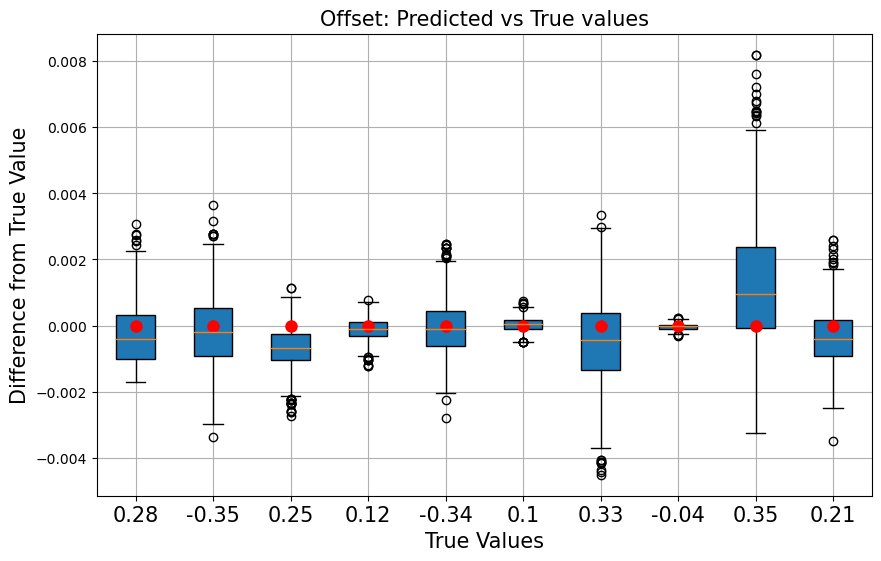

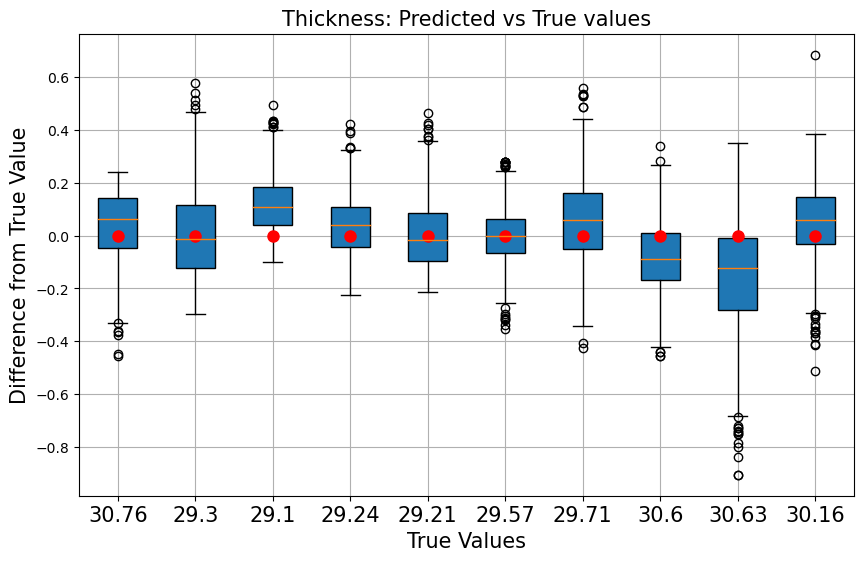

In [33]:
names = ['Overetch', 'Offset', 'Thickness']
for i in range(3):
    #Create a dataset containing all the same parameter samples 
    plot_data = []
    true_val = []
    for j in range(n):
        true_val.append(X_values[random_samples[j]][i])
        plot_data.append(samples_box[j][i]- true_val[j])

    # Plot box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(plot_data, patch_artist=True)

    # Plot the mean values
    for idx, mean in enumerate(true_val):
        plt.plot(idx + 1, mean*0, 'ro', label='Mean', markersize=8)

    # Add labels and title
    plt.xlabel('True Values',size= 15)
    plt.ylabel('Difference from True Value',size= 15)
    plt.title(names[i] + ': Predicted vs True values',size= 15)
    plt.xticks(np.arange(1, n + 1), np.round(true_val,2), size= 15)
    plt.grid(True)
    plt.show()

### Comparison of Time/ESS on more samples

In [90]:
np.random.seed(1008)
random_samples = np.random.randint(0, 160, 20)
random_samples

array([ 24, 105, 145,  83,  20, 128, 103,  37,  49,  68, 133, 137,   5,
        86, 146,   2,  11, 131, 135,  83])

Fine model only 

In [96]:
n = 20
print('The extracted samples are: ', random_samples)

Times_fine = []
Time_ESS_fine = []
ESS_fine = []
i = 1
for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=fine_model , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, fine_model)
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.1) 

    # Perform the MH Algorithm 
    start = timeit.default_timer()
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    ess = az.ess(idata)
    t = end-start
    Times_fine.append(t)
    e = (ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3
    ESS_fine.append(e)
    Time_ESS_fine.append(t/e)
    print('Done ',i,'/25 iterations')
    print('Time/ESS =', t/e )
    i = i+1

print('Times of the fine model:\n', Times_fine)
print('\nEffective Sample Sizes of fine model:\n ', ESS_fine)
print('Time/ESS: \n',Time_ESS_fine)

The extracted samples are:  [ 24 105 145  83  20 128 103  37  49  68 133 137   5  86 146   2  11 131
 135  83]
[ 0.462475 -0.221586 30.575526]
Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:22<00:00, 269.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  1 /25 iterations
Time/ESS = 0.03923504660034422
[ 0.128917  0.285462 30.259288]
Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:21<00:00, 273.70it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  2 /25 iterations
Time/ESS = 0.2274223726975655
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α = 0.46: 100%|██████████| 6000/6000 [00:21<00:00, 273.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  3 /25 iterations
Time/ESS = 0.04268862634214497
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α = 0.25: 100%|██████████| 6000/6000 [00:22<00:00, 271.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  4 /25 iterations
Time/ESS = 0.04941974896235256
[ 0.211305  0.183238 29.364769]
Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:21<00:00, 273.93it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  5 /25 iterations
Time/ESS = 0.04666010167829121
[ 0.164689 -0.39078  29.330976]
Sampling chain 1/1


Running chain, α = 0.38: 100%|██████████| 6000/6000 [00:22<00:00, 268.98it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  6 /25 iterations
Time/ESS = 0.048949155653934755
[ 0.115936  0.047662 30.639655]
Sampling chain 1/1


Running chain, α = 0.41: 100%|██████████| 6000/6000 [00:21<00:00, 276.32it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  7 /25 iterations
Time/ESS = 0.04724385335946072
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α = 0.33: 100%|██████████| 6000/6000 [00:21<00:00, 275.17it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  8 /25 iterations
Time/ESS = 0.053120998208980474
[ 0.254074 -0.463495 29.71306 ]
Sampling chain 1/1


Running chain, α = 0.37: 100%|██████████| 6000/6000 [00:22<00:00, 272.05it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  9 /25 iterations
Time/ESS = 0.04984049723769682
[ 0.16726  -0.125753 29.617864]
Sampling chain 1/1


Running chain, α = 0.29: 100%|██████████| 6000/6000 [00:21<00:00, 274.61it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  10 /25 iterations
Time/ESS = 0.0384933632597714
[ 0.32954  -0.167992 30.299452]
Sampling chain 1/1


Running chain, α = 0.38: 100%|██████████| 6000/6000 [00:21<00:00, 274.59it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  11 /25 iterations
Time/ESS = 0.042868397737864695
[ 0.423757 -0.347213 30.887732]
Sampling chain 1/1


Running chain, α = 0.35: 100%|██████████| 6000/6000 [00:22<00:00, 269.75it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  12 /25 iterations
Time/ESS = 0.051872040109260296
[ 0.230536 -0.068871 30.351452]
Sampling chain 1/1


Running chain, α = 0.27: 100%|██████████| 6000/6000 [00:22<00:00, 266.53it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  13 /25 iterations
Time/ESS = 0.053935091090091807
[ 0.23733   0.428998 29.895089]
Sampling chain 1/1


Running chain, α = 0.37: 100%|██████████| 6000/6000 [00:22<00:00, 272.23it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  14 /25 iterations
Time/ESS = 0.09329517959354273
[ 0.208638 -0.382417 30.991585]
Sampling chain 1/1


Running chain, α = 0.27: 100%|██████████| 6000/6000 [00:22<00:00, 269.09it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  15 /25 iterations
Time/ESS = 0.04858987245953284
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 6000/6000 [00:21<00:00, 272.80it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  16 /25 iterations
Time/ESS = 0.0501083685999369
[ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
Sampling chain 1/1


Running chain, α = 0.38: 100%|██████████| 6000/6000 [00:22<00:00, 265.66it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  17 /25 iterations
Time/ESS = 0.04777597151119443
[ 0.272002  0.083286 30.390501]
Sampling chain 1/1


Running chain, α = 0.32: 100%|██████████| 6000/6000 [00:22<00:00, 270.45it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  18 /25 iterations
Time/ESS = 0.042501983155048266
[ 0.258854  0.381479 29.366104]
Sampling chain 1/1


Running chain, α = 0.37: 100%|██████████| 6000/6000 [00:22<00:00, 261.28it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  19 /25 iterations
Time/ESS = 0.26725959639605235
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:24<00:00, 247.28it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  20 /25 iterations
Time/ESS = 0.05832176386817481
Times of the fine model:
 [22.27644737501396, 21.92620658298256, 21.932813791994704, 22.13888637497439, 21.90740850000293, 22.31172462500399, 21.718417582975235, 21.80931887499173, 22.05847558399546, 21.85366404199158, 21.855134959012503, 22.247236249997513, 22.515887625020696, 22.044390708004357, 22.301153916021576, 21.998305124987382, 22.590392458980205, 22.189385374978883, 22.968415125011234, 24.26860070900875]

Effective Sample Sizes of fine model:
  [567.7691070925993, 96.41182757397762, 513.7858879834981, 447.97650412671175, 469.5105178091679, 455.8142898877659, 459.7088518103712, 410.55928183414136, 442.5813707033314, 567.7255036020814, 509.8192634269685, 428.8868570261977, 417.46267911943875, 236.28649201432185, 458.96712189550755, 439.01459456046, 472.8400437380333, 522.0788238052673, 85.94046924689023, 416.1156847701534]
Time/ESS: 
 [0.03923504660034422, 0.2274223726975655, 0.04268862634214497, 0.04941974896235256, 0.0466

MDA

In [95]:
n = 20
print('The extracted samples are: ', random_samples)

Times_mda = []
Time_ESS_mda = []
ESS_mda = []
i = 1
for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 
    # set the likelihood
    y_distr_fine= tda.GaussianLogLike(y_observed, cov_likelihood) 
    y_distr_coarse = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    start = timeit.default_timer()
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse,model_lf)
    my_posterior_fine = tda.Posterior(x_distribution, y_distr_fine, fine_model)
    my_posteriors = [my_posterior_coarse, my_posterior_fine]    
    
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.075) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posteriors, my_proposal, iterations=3300, n_chains=1, initial_parameters=init_guess,subsampling_rate = 3)
    end = timeit.default_timer()
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    ess = az.ess(idata)
    t = end-start
    Times_mda.append(t)
    e = (ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3
    ESS_mda.append(e)
    Time_ESS_mda.append(t/e)
    print('Done ',i,'/25 iterations')
    print('Time/ESS =', t/e )
    i = i+1
    

print('Times of the fine model:\n', Times_mda)
print('\nEffective Sample Sizes of fine model:\n ', ESS_mda)
print('Time/ESS: \n',Time_ESS_mda)

The extracted samples are:  [ 24 105 145  83  20 128 103  37  49  68 133 137   5  86 146   2  11 131
 135  83]
[ 0.462475 -0.221586 30.575526]
Sampling chain 1/1


Running chain, α_c = 0.710, α_f = 0.29: 100%|██████████| 3300/3300 [00:12<00:00, 254.65it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  1 /25 iterations
Time/ESS = 0.03388801002725871
[ 0.128917  0.285462 30.259288]
Sampling chain 1/1


Running chain, α_c = 0.610, α_f = 0.30: 100%|██████████| 3300/3300 [00:12<00:00, 258.63it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  2 /25 iterations
Time/ESS = 0.06291343081083642
[ 0.418297  0.210256 29.835135]
Sampling chain 1/1


Running chain, α_c = 0.743, α_f = 0.33: 100%|██████████| 3300/3300 [00:13<00:00, 252.95it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  3 /25 iterations
Time/ESS = 0.0341785145469651
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α_c = 0.550, α_f = 0.15: 100%|██████████| 3300/3300 [00:12<00:00, 262.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  4 /25 iterations
Time/ESS = 0.03628226023586314
[ 0.211305  0.183238 29.364769]
Sampling chain 1/1


Running chain, α_c = 0.587, α_f = 0.23: 100%|██████████| 3300/3300 [00:12<00:00, 255.32it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  5 /25 iterations
Time/ESS = 0.036199676722029964
[ 0.164689 -0.39078  29.330976]
Sampling chain 1/1


Running chain, α_c = 0.623, α_f = 0.34: 100%|██████████| 3300/3300 [00:12<00:00, 256.06it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  6 /25 iterations
Time/ESS = 0.026699688730054516
[ 0.115936  0.047662 30.639655]
Sampling chain 1/1


Running chain, α_c = 0.690, α_f = 0.30: 100%|██████████| 3300/3300 [00:12<00:00, 254.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  7 /25 iterations
Time/ESS = 0.037745750908121184
[ 0.46283   0.063884 30.828432]
Sampling chain 1/1


Running chain, α_c = 0.637, α_f = 0.35: 100%|██████████| 3300/3300 [00:12<00:00, 256.50it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  8 /25 iterations
Time/ESS = 0.032606450978222
[ 0.254074 -0.463495 29.71306 ]
Sampling chain 1/1


Running chain, α_c = 0.650, α_f = 0.31: 100%|██████████| 3300/3300 [00:13<00:00, 249.52it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  9 /25 iterations
Time/ESS = 0.029658043395601314
[ 0.16726  -0.125753 29.617864]
Sampling chain 1/1


Running chain, α_c = 0.660, α_f = 0.34: 100%|██████████| 3300/3300 [00:13<00:00, 252.18it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  10 /25 iterations
Time/ESS = 0.031171469425706363
[ 0.32954  -0.167992 30.299452]
Sampling chain 1/1


Running chain, α_c = 0.667, α_f = 0.25: 100%|██████████| 3300/3300 [00:12<00:00, 255.40it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  11 /25 iterations
Time/ESS = 0.03611147100231903
[ 0.423757 -0.347213 30.887732]
Sampling chain 1/1


Running chain, α_c = 0.547, α_f = 0.27: 100%|██████████| 3300/3300 [00:13<00:00, 251.68it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  12 /25 iterations
Time/ESS = 0.03567693448958215
[ 0.230536 -0.068871 30.351452]
Sampling chain 1/1


Running chain, α_c = 0.693, α_f = 0.31: 100%|██████████| 3300/3300 [00:13<00:00, 246.64it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  13 /25 iterations
Time/ESS = 0.03524956706499413
[ 0.23733   0.428998 29.895089]
Sampling chain 1/1


Running chain, α_c = 0.663, α_f = 0.30: 100%|██████████| 3300/3300 [00:12<00:00, 255.86it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  14 /25 iterations
Time/ESS = 0.12485197083141518
[ 0.208638 -0.382417 30.991585]
Sampling chain 1/1


Running chain, α_c = 0.563, α_f = 0.40: 100%|██████████| 3300/3300 [00:12<00:00, 256.37it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  15 /25 iterations
Time/ESS = 0.03080175275720265
[ 0.122269  0.396304 29.130577]
Sampling chain 1/1


Running chain, α_c = 0.647, α_f = 0.39: 100%|██████████| 3300/3300 [00:12<00:00, 257.42it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  16 /25 iterations
Time/ESS = 0.03853662218025282
[ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
Sampling chain 1/1


Running chain, α_c = 0.697, α_f = 0.34: 100%|██████████| 3300/3300 [00:13<00:00, 251.91it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  17 /25 iterations
Time/ESS = 0.03296764057025287
[ 0.272002  0.083286 30.390501]
Sampling chain 1/1


Running chain, α_c = 0.687, α_f = 0.27: 100%|██████████| 3300/3300 [00:13<00:00, 251.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  18 /25 iterations
Time/ESS = 0.04630634228675015
[ 0.258854  0.381479 29.366104]
Sampling chain 1/1


Running chain, α_c = 0.453, α_f = 0.35: 100%|██████████| 3300/3300 [00:11<00:00, 279.13it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  19 /25 iterations
Time/ESS = 0.10440704604383072
[ 0.12017   0.177757 29.019343]
Sampling chain 1/1


Running chain, α_c = 0.527, α_f = 0.23: 100%|██████████| 3300/3300 [00:12<00:00, 260.29it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Done  20 /25 iterations
Time/ESS = 0.04069543631687217
Times of the fine model:
 [12.984553750022314, 12.77246904198546, 13.057132166984957, 12.575594750000164, 12.936547999997856, 12.89984133298276, 12.9834092920064, 12.876932540995767, 13.237342083011754, 13.097751458000857, 12.932942500017816, 13.127228291996289, 13.392459124996094, 12.91152287501609, 12.885792624991154, 12.82917145799729, 13.11122229200555, 13.170783665991621, 11.844861542020226, 12.688255708984798]

Effective Sample Sizes of fine model:
  [383.1607031388933, 203.01657177763525, 382.02749124871997, 346.6045022622333, 357.3663958199131, 483.14575736840135, 343.9700888084056, 394.91978288579554, 446.33227844609024, 420.18395986168866, 358.1394537815222, 367.9472039793527, 379.932584712394, 103.41465007749241, 418.3460833078064, 332.9085615752617, 397.6997463335601, 284.42720836018697, 113.44887142049474, 311.7857149924277]
Time/ESS: 
 [0.03388801002725871, 0.06291343081083642, 0.0341785145469651, 0.03628226023586314,

Compare the two distribution of parameters

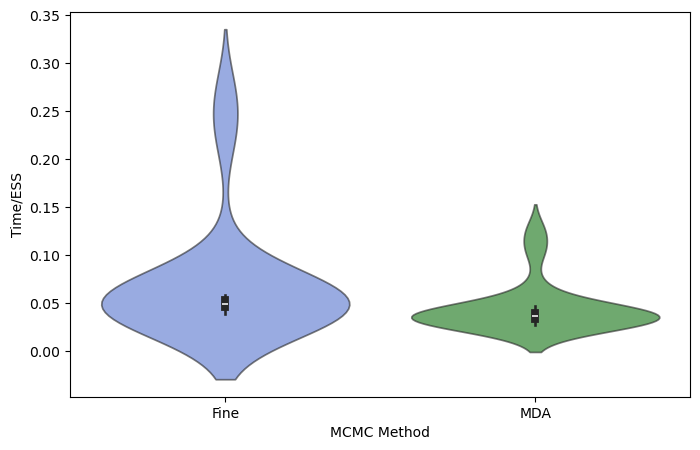

In [110]:
data = [Time_ESS_fine, Time_ESS_mda]

# Labels for the datasets
labels = ['Fine', 'MDA']

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=data, palette=['royalblue', 'green'], alpha=0.6)
plt.xticks([0, 1], labels)
plt.xlabel('MCMC Method')
plt.ylabel('Time/ESS')
#plt.title('Violin Plot of Time/ESS for Fine model and MDA')
plt.show()

In [98]:
np.mean(Time_ESS_fine)/np.mean(Time_ESS_mda)

1.5779976992427356

In [40]:
Time_ESS_mda = [0.03388801002725871, 0.06291343081083642, 0.0341785145469651, 0.03628226023586314, 0.036199676722029964, 0.026699688730054516, 0.037745750908121184, 0.032606450978222, 0.029658043395601314, 0.031171469425706363, 0.03611147100231903, 0.03567693448958215, 0.03524956706499413, 0.12485197083141518, 0.03080175275720265, 0.03853662218025282, 0.03296764057025287, 0.04630634228675015, 0.10440704604383072, 0.04069543631687217]
Time_ESS_fine =  [0.03923504660034422, 0.2274223726975655, 0.04268862634214497, 0.04941974896235256, 0.04666010167829121, 0.048949155653934755, 0.04724385335946072, 0.053120998208980474, 0.04984049723769682, 0.0384933632597714, 0.042868397737864695, 0.051872040109260296, 0.053935091090091807, 0.09329517959354273, 0.04858987245953284, 0.0501083685999369, 0.04777597151119443, 0.042501983155048266, 0.26725959639605235, 0.05832176386817481]

In [42]:
print('Standerd deviation of fine method', np.std(Time_ESS_fine))
print('Standerd deviation of mda method', np.std(Time_ESS_mda))

Standerd deviation of fine method 0.0604585739230374
Standerd deviation of mda method 0.02474776569969071
